**Изучение ансамблей решающих деревьев**

Использьвание алгоритма - решающее дерево может приводить к высокой дисперисии предсказаний. Для того, чтобы это избежать исползуются методы, которые обощают под названием ансамбли решающих деревьев. Выделяют следующие методы:

- Bagging;
- Random Forests;
- Boosting;
- Bayesian Additive Regression Trees.

**Источники**

- <a href="https://hastie.su.domains/ISLR2/ISLRv2_website.pdf">ISLR</a>;
- <a herf="https://hastie.su.domains/ISLR2/ISLRv2_website.pdf">Собрание возможностей sklearn посвященных ансамблям</a>;

In [6]:
import pandas as pd
import numpy as np

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score

from tqdm import tqdm

import matplotlib.pyplot as plt

# Баггинг

Предполагает бутстрапирование обучающей выборки и подгонку множестава деревьев. Для получания предсказаний результаты каждого дерева аггрегируют (обычно усредняют). Вообще говоря, баггинг можно ложить не только на деревья но и на KNN модели.

sklearn предлагает, для проведения баггинга так называемый "мета оценщик" ("meta estimator"), в который заворачивается любой другой оценщик по желанию. 

### *Сравнение с единичным деревом*

Создам выборку и на ней попробую оценить обычное дерево и баггинг на дереве. Результаты сравним.

In [31]:
sample_size = 500
np.random.seed(10)

data = pd.DataFrame({
    "x" : np.random.rand(sample_size)
})

f_x = lambda x: 15*x**3 - 15*x**2 + x 

data["y"] = f_x(data["x"]) + np.random.uniform(0, 1, sample_size)

In [3]:
ccp_alphas = DecisionTreeRegressor().\
cost_complexity_pruning_path(
    data[["x"]], data["y"]
)["ccp_alphas"]

clf = DecisionTreeRegressor()
MSEs = {}

for alpha in tqdm(ccp_alphas):
    clf.set_params(ccp_alpha = alpha)
    MSE = cross_val_score(
        clf, data[["x"]], 
        data["y"], 
        cv = 20,
        scoring = "neg_mean_squared_error"
    )
    MSEs[alpha] = MSE

MSEs = pd.DataFrame(MSEs)

100%|██████████| 345/345 [00:24<00:00, 13.89it/s]


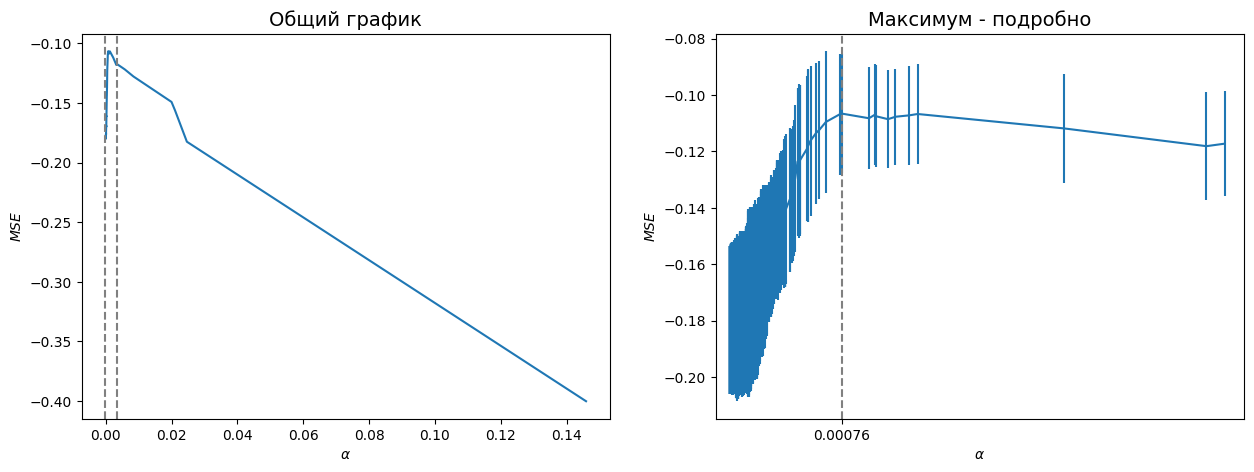

In [4]:
plt.figure(figsize = [15, 5])

def set_params():
    plt.xlabel("$\\alpha$")
    plt.ylabel("$MSE$")

bordres = [-0.0001, 0.0035]

plt.subplot(121)
plt.plot(MSEs.columns, MSEs.mean())
set_params()
for b in bordres:
    plt.axvline(b, color = "gray", linestyle = "dashed")
plt.title("Общий график", fontsize = 14)


cond = (MSEs.columns > bordres[0]) & (MSEs.columns < bordres[1])

plt.subplot(122)
plt.errorbar(MSEs.columns[cond], MSEs.mean()[cond], MSEs.std()[cond])
plt.axvline(
    MSEs.mean().idxmax(), 
    color = "gray", 
    linestyle = "dashed"
)
plt.xlim(bordres)
set_params()
plt.title("Максимум - подробно", fontsize = 14)
plt.xticks([MSEs.mean().idxmax()])

del set_params

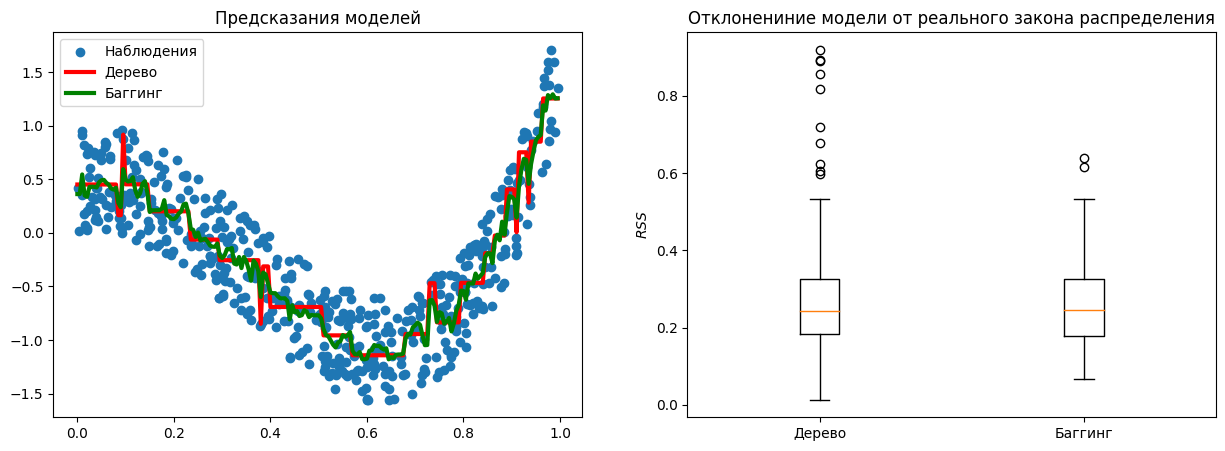

In [30]:
x_range = np.arange(0, 1, 0.005)

clf = DecisionTreeRegressor(ccp_alpha=0.00076)
clf.fit(data[["x"]].to_numpy(), data["y"])
tree_predict = clf.predict(x_range[:, np.newaxis])

bclf = BaggingRegressor(clf, n_estimators=200).fit(data[["x"]].to_numpy(), data["y"])
bagging_predict = bclf.predict(x_range[:, np.newaxis])

plt.figure(figsize = [15, 5])

plt.subplot(121)
plt.scatter(data["x"], data["y"])
for pred, col in zip(
    [tree_predict, bagging_predict],
    ["red", "green"]
):
    plt.plot(
        x_range, pred,
        color = col, linewidth = 3
    )

plt.legend(["Наблюдения", "Дерево", "Баггинг"])
plt.title("Предсказания моделей")

plt.subplot(122)
plt.boxplot((
    (f_x(x_range) - tree_predict)**2, 
    (f_x(x_range) - bagging_predict)**2)
)

plt.title("Отклонениние модели от реального закона распределения")
plt.ylabel("$RSS$")
ans = plt.xticks([1,2], ["Дерево", "Баггинг"])

Все складывается так, что баггированная модель "сглаживает" неготорые скачки, которые проявляются в одиночном дереве.